In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..") # Adds the module to path

# Example 2. Single particle tracking



## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

import datasets

datasets.load("ParticleTracking")

IMAGE_SIZE = 51

ParticleTracking already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 51 by 51 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 1 micron and 2 microns, and a refractive index between 1.5 and 1.6. Its position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = dt.MieSphere(
    position=lambda: np.random.uniform(IMAGE_SIZE / 2 - 3, IMAGE_SIZE / 2 + 3, 2) * dt.units.pixel,
    z=lambda: np.random.uniform(0, 5) * dt.units.pixel,
    radius=300e-9 ,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
    L=10
)


The particle is imaged using a brightfield microscope with NA between 0.15 and 0.25 and a illuminating laser wavelength between 400 and 700 nm. To simulate the broad spectrum we define 10 individual optical devices, each imaging the particle at a single wavelength. The result is then averaged.

In [4]:

spectrum = np.linspace(500e-9, 700e-9, 5)

imaged_particle_list = []


for wavelength in spectrum:
    single_wavelength_optics = dt.Brightfield(
        NA=0.8,
        resolution=1e-6,
        magnification=15,
        wavelength=wavelength,
        padding=(32, 32, 32, 32),
        output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    )
    
    imaged_particle_list.append(
        single_wavelength_optics(particle)
    )

dataset = sum(imaged_particle_list) / len(imaged_particle_list)

### 2.2 Defining the training label

The training label is extracted directly from the image as the `position` property divided by the image size, such that the posible values are contained within -0.5 and 0.5.

In [5]:
def get_label(image):
    px = np.array(image.get_property("position")) / IMAGE_SIZE - 0.5
    return px

### 2.3 Visualizing the dataset

We resolve and show 16 images, with a green circle indicating the particle position.

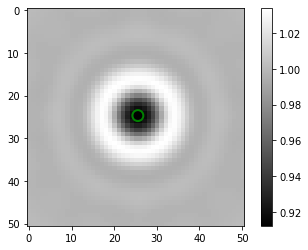

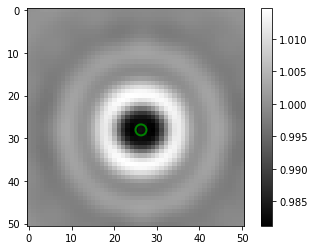

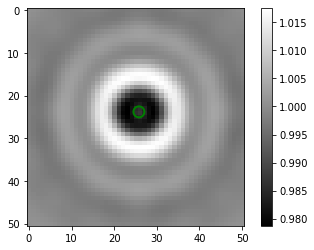

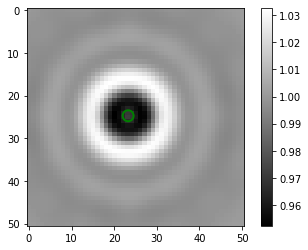

In [6]:
NUMBER_OF_IMAGES = 4

for _ in range(NUMBER_OF_IMAGES):

    dataset.update()
    image_of_particle = dataset.resolve()
    position_of_particle = get_label(image_of_particle) * IMAGE_SIZE + IMAGE_SIZE / 2
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.colorbar()
    plt.scatter(position_of_particle[1], position_of_particle[0], s=120, facecolors='none', edgecolors="g", linewidth=2)
    plt.show()
    

### 2.4 Augmenting dataset

Simulating mie particles is slow. To speed up training we implement augmentation techniques. Here we flip and mirror the image. Note that DeepTrack ensures that the position is still correct after the augmentation. 

In [7]:
augmented_dataset = dt.Reuse(dataset, 8) >> dt.FlipLR() >> dt.FlipUD() >> dt.FlipDiagonal()

We add noises after augmentation. This allows the augmented images to be more distinct.

In [8]:
gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 1e-4,
)

noise = dt.Poisson(
    min_snr=5,
    max_snr=100,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr - min_snr),
    background=1
)

normalization = dt.NormalizeMinMax(lambda: np.random.rand() * 0.2, lambda: 0.8 + np.random.rand() * 0.2)

data_pipeline = augmented_dataset >> gradient >> noise >> normalization



[22.79797375 22.38587531]


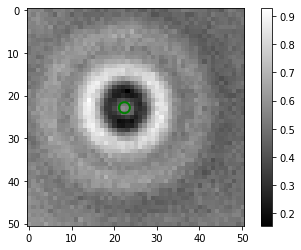

[27.61412469 22.79797375]


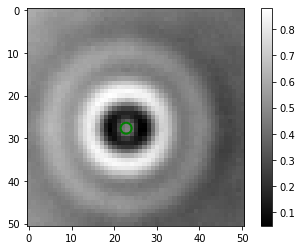

[22.38587531 22.79797375]


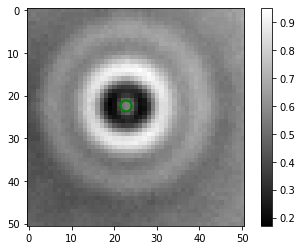

[22.38587531 22.79797375]


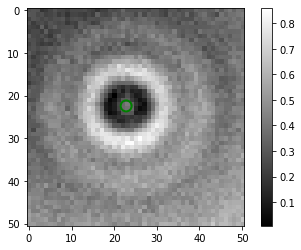

In [9]:
NUMBER_OF_IMAGES = 4

for _ in range(NUMBER_OF_IMAGES):

    data_pipeline.update()
    image_of_particle = data_pipeline()
    position_of_particle = get_label(image_of_particle) * IMAGE_SIZE + IMAGE_SIZE / 2
    print(position_of_particle)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.colorbar()
    plt.scatter(position_of_particle[1], position_of_particle[0], s=120, facecolors='none', edgecolors="g", linewidth=2)
    plt.show()
    

## 3. Defining the network

The network used is a Convolutional network, with mse as loss.

In [10]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers
def pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1))) * IMAGE_SIZE

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16, 32, 64),
    dense_layers_dimensions=(32, 32),
    steps_per_pooling=1,
    number_of_outputs=2,
    loss="mse",
    metrics=[pixel_error],
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu"),
    pooling_block=dt.layers.PoolingBlock(padding="valid")
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 51, 51, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 51, 51, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 51, 51, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0     

## 4. Training the network

We use the `ContinuousGenerator` to generate the images. It creates a new thread and generates images while the model is training. 

Set TRAIN_MODEL to True to train the model, otherwise a pretrained model is downloaded.

Generating 1008 / 1000 samples before starting training
Epoch 1/250
15/15 [==============================] - 1s 44ms/step - loss: 1.0657e-05 - pixel_error: 0.1883 - val_loss: 1.0103e-05 - val_pixel_error: 0.1819
Epoch 2/250
15/15 [==============================] - 0s 18ms/step - loss: 1.1356e-05 - pixel_error: 0.2038 - val_loss: 1.3371e-05 - val_pixel_error: 0.2185
Epoch 3/250
15/15 [==============================] - 0s 22ms/step - loss: 9.8414e-06 - pixel_error: 0.1875 - val_loss: 1.2731e-05 - val_pixel_error: 0.2094
Epoch 4/250
15/15 [==============================] - 0s 15ms/step - loss: 8.7149e-06 - pixel_error: 0.1724 - val_loss: 1.0754e-05 - val_pixel_error: 0.1889
Epoch 5/250
15/15 [==============================] - 0s 18ms/step - loss: 7.8261e-06 - pixel_error: 0.1669 - val_loss: 1.1556e-05 - val_pixel_error: 0.2021
Epoch 6/250
15/15 [==============================] - 0s 20ms/step - loss: 8.6323e-06 - pixel_error: 0.1772 - val_loss: 1.0491e-05 - val_pixel_error: 0.1831
Epoch 7/

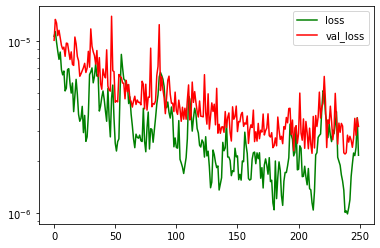

In [12]:
TRAIN_MODEL = True

from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 200

validation_set = [data_pipeline.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        data_pipeline & (data_pipeline >> get_label),
        min_data_size=int(1e3),
        max_data_size=int(2e3),
        batch_size=64,
        max_epochs_per_sample=25
    )

    histories = []

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=250
        )

    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["loss", "val_loss"])
    plt.yscale('log')
    plt.show()
    
else:
    model_path = datasets.load_model("ParticleTracking")
    model.load_weights(model_path)

## 5. Evaluating the network

### 5.1 Prediction vs actual

We show the prediction of each output versus the ground truth

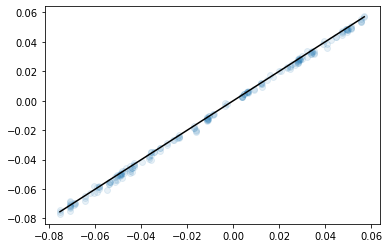

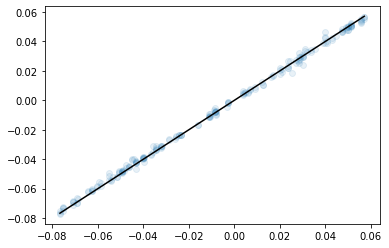

In [13]:
validation_prediction = model.predict(np.array(validation_set))
labels = np.array(validation_labels)
for col in range(validation_prediction.shape[-1]):
    label_col = labels[:, col]
    prediction_col = validation_prediction[:, col]
    plt.scatter(label_col, prediction_col, alpha=0.1)
    
    plt.plot([np.min(label_col), np.max(label_col)], 
             [np.min(label_col), np.max(label_col)], c='k')
    plt.show()

### 5.3 Prediction vs property value

We show the the pixel error as a function of some properties.

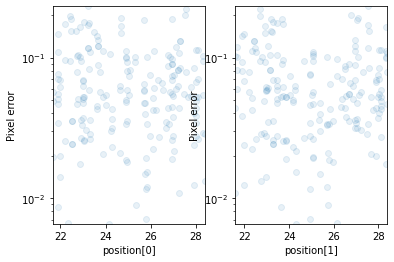

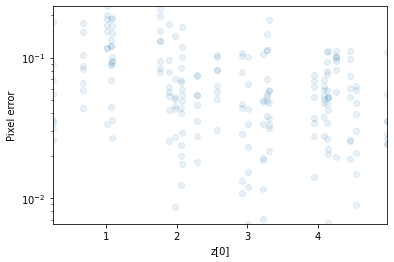

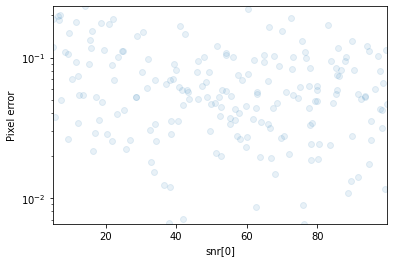

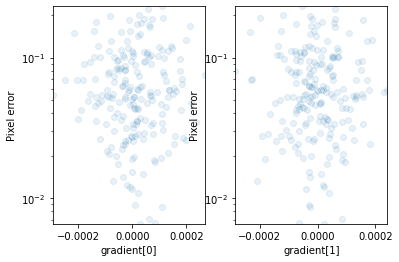

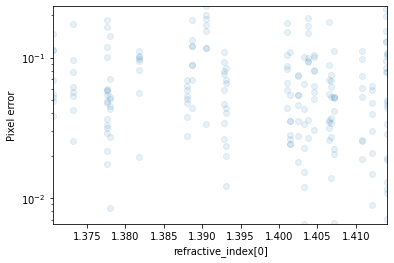

<ipython-input-14-817c2c397237>:20: UserWarning: Attempting to set identical left == right == 0.8 results in singular transformations; automatically expanding.
  plt.xlim([np.min(values), np.max(values)])


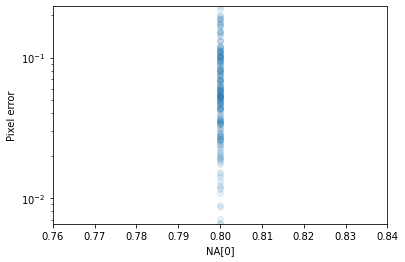

In [14]:
properties = ["position", "z", "snr", "gradient", "refractive_index", "NA"]

validation_prediction = model.predict(np.array(validation_set))

snr = [image.get_property("snr") for image in validation_set]

validation_error = np.mean(np.abs(validation_prediction - validation_labels), axis=-1) * 51

for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
    
    for col in range(property_values.shape[1]):
        values = property_values[:, col]

        plt.subplot(1, property_values.shape[1], col + 1)

        plt.scatter(values, validation_error, alpha=0.1)
        plt.xlim([np.min(values), np.max(values)])
        plt.ylim([np.min(validation_error), np.max(validation_error)])
        plt.yscale("log")
        plt.ylabel("Pixel error")
        plt.xlabel("{0}[{1}]".format(property_name, col))

    
    plt.show()

### 5.3 Experimental data
We play some experimental videos tracked by the DeepTrack model, compared to radial center method.

In [15]:
import cv2
import IPython
import numpy as np

from radialcenter import radialcenter
import matplotlib.pyplot as plt

def track_video(video, frames_to_track):
    video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize variables
    predicted_positions = np.zeros((frames_to_track, 2))
    predicted_positions_radial = np.zeros((frames_to_track, 2))

    # Track the positions of the particles frame by frame

    for i in range(frames_to_track):

        # Read the current frame from the video
        (ret, frame) = video.read()

        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

        # Convert color image to grayscale.
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        
        radial_x, radial_y = radialcenter(frame)
        predicted_positions_radial[i, 0] = radial_x 
        predicted_positions_radial[i, 1] = radial_y

        ### Resize the frame
        frame_resize = cv2.resize(frame, (51, 51))

        predicted_position = model.predict(np.reshape(frame_resize, (1, 51, 51, 1)))
        
        predicted_position_y = predicted_position[0,0] * video_width + video_width / 2 + 1
        predicted_position_x = predicted_position[0,1] * video_height + video_height / 2 + 1
        
        predicted_positions[i, 0] = predicted_position_x
        predicted_positions[i, 1] = predicted_position_y

        IPython.display.clear_output(wait=True)

        plt.imshow(frame, cmap="gray")
        plt.scatter(predicted_position_x, predicted_position_y, marker='o', s=360, edgecolor='b', facecolor='none')
        plt.scatter(radial_x, radial_y, marker='x', s=240, c="g")

        plt.show()
        
    return predicted_positions, predicted_positions_radial


Here, the blue circle is deeptrack, and the cross is radial center

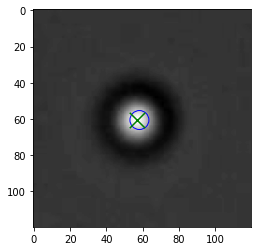

In [16]:
video = cv2.VideoCapture("./datasets/ParticleTracking/ideal.avi")
p, pr = track_video(video, 100)

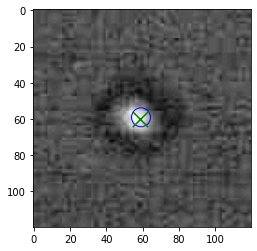

In [17]:
video = cv2.VideoCapture("./datasets/ParticleTracking/bad.avi")
p, pr = track_video(video, 100)